In [1]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

laberinto = np.array([
    [0, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0],
    [1, 1, 0, 1, 0],
    [0, 0, 0, 1, 0]
])

estado_inicial = (0, 0)
estado_objetivo_1 = (4, 4)
estado_objetivo_2 = (4, 0)

# Parámetros de Q-Learning
num_estados = laberinto.shape
num_acciones = 4
alpha = 0.6  # Tasa de aprendizaje
gamma = 0.9  # Factor de descuento
epsilon_inicial = 1.0  # Valor inicial de epsilon
epsilon_minimo = 0.1  # Valor mínimo de epsilon
num_episodios_decaimiento = 50  # epsilon se reduce gradualmente

# Inicializar la tabla de valores Q
Q = np.zeros((num_estados[0], num_estados[1], num_acciones))

# Función epsilon-greedy para seleccionar acciones
def seleccionar_accion(estado, epsilon):
    if random.uniform(0, 1) < epsilon:
        return random.choice(range(num_acciones))
    else:
        return np.argmax(Q[estado[0], estado[1]])

# Función para mover al agente en el laberinto
def mover_agente(estado, accion):
    if accion == 0:  # Mover hacia arriba
        nuevo_estado = max(estado[0] - 1, 0), estado[1]
    elif accion == 1:  # Mover hacia abajo
        nuevo_estado = min(estado[0] + 1, num_estados[0] - 1), estado[1]
    elif accion == 2:  # Mover a la izquierda
        nuevo_estado = estado[0], max(estado[1] - 1, 0)
    elif accion == 3:  # Mover a la derecha
        nuevo_estado = estado[0], min(estado[1] + 1, num_estados[1] - 1)
    # Si el nuevo estado es una pared, no mover al agente
    if laberinto[nuevo_estado[0], nuevo_estado[1]] == 1:
        return estado
    return nuevo_estado

# Función para imprimir el laberinto
def imprimir_laberinto(estado):
    laberinto_visual = np.copy(laberinto)
    laberinto_visual[estado[0], estado[1]] = 2  # Marcar la posición actual del agente
    for fila in laberinto_visual:
        print(''.join(['#' if cell == 1 else 'A' if cell == 2 else ' ' for cell in fila]))

# Función para dibujar el laberinto
def dibujar_laberinto(estado):
    laberinto_visual = np.copy(laberinto)
    laberinto_visual[estado[0], estado[1]] = 2  # Marcar la posición actual del agente
    plt.imshow(laberinto_visual, cmap='hot')
    plt.show()
    plt.pause(0.4)  # Pausa antes de borrar la salida
    clear_output(wait=True)  # Borra la salida de la celda

# Función para obtener la dirección a partir del número de acción
def obtener_direccion(accion):
    if accion == 0:
        return "arriba"
    elif accion == 1:
        return "abajo"
    elif accion == 2:
        return "izquierda"
    elif accion == 3:
        return "derecha"
    else:
        return "acción desconocida"

# Función para ejecutar un episodio
def ejecutar_episodio(estado_inicial, estado_objetivo, epsilon, objetivo_actual):
    estado = estado_inicial
    total_recompensa = 0  # Acumulador de recompensa por episodio

    while estado != estado_objetivo:
        accion = seleccionar_accion(estado, epsilon)
        nueva_estado = mover_agente(estado, accion)

        # Calcular la recompensa
        recompensa = -1  # Movimiento normal
        if laberinto[nueva_estado[0], nueva_estado[1]] == 1:
            recompensa = -100  # Penalización alta
        elif nueva_estado == estado_objetivo:
            recompensa = 100  # Objetivo

        total_recompensa += recompensa

        # Actualizar la tabla Q de manera incremental
        Q[estado[0], estado[1], accion] += alpha * (
            recompensa + gamma * np.max(Q[nueva_estado[0], nueva_estado[1]]) - Q[estado[0], estado[1], accion]
        )

        estado = nueva_estado

    # Imprimir la cantidad total de basuras recolectadas al final del episodio
    print(f"Objetivo {objetivo_actual}, Episodio: Basuras recolectadas: {total_recompensa}")

    return total_recompensa

# Entrenamiento
num_episodios_objetivo_1 = 1000
num_episodios_objetivo_2 = 1000

# Fase de entrenamiento para el primer objetivo
epsilon = epsilon_inicial
total_recompensa_objetivo_1 = 0

for episodio in range(num_episodios_objetivo_1):
    total_recompensa_objetivo_1 += ejecutar_episodio(
        estado_inicial, estado_objetivo_1, epsilon, 1
    )

    # Decaimiento de epsilon al final de cada episodio
    if episodio < num_episodios_decaimiento:
        epsilon -= (epsilon_inicial - epsilon_minimo) / num_episodios_decaimiento
    else:
        epsilon = epsilon_minimo

# Calcular promedio para Q_objetivo_1
Q_objetivo_1 = np.copy(Q) / num_episodios_objetivo_1

# Restablecer la tabla Q para el segundo objetivo
Q = np.zeros((num_estados[0], num_estados[1], num_acciones))

# Fase de entrenamiento para el segundo objetivo
epsilon = epsilon_inicial

# Actualizar el estado inicial para el segundo objetivo
estado_inicial = estado_objetivo_1  # Cambiar al objetivo 1
total_recompensa_objetivo_2 = 0

for episodio in range(num_episodios_objetivo_2):
    total_recompensa_objetivo_2 += ejecutar_episodio(
        estado_inicial, estado_objetivo_2, epsilon, 2
    )

    # Decaimiento de epsilon al final de cada episodio
    if episodio < num_episodios_decaimiento:
        epsilon -= (epsilon_inicial - epsilon_minimo) / num_episodios_decaimiento
    else:
        epsilon = epsilon_minimo

# Calcular promedio para Q_objetivo_2
Q_objetivo_2 = np.copy(Q) / num_episodios_objetivo_2

# Usar la nueva tabla Q para seleccionar acciones hacia el objetivo 2
Q = Q_objetivo_2

# Restaurar el estado inicial al valor original
estado_inicial = (0, 0)

# Seguir la política óptima desde el estado inicial hasta el objetivo 1
total_recompensa_optimo_1 = ejecutar_episodio(
    estado_inicial, estado_objetivo_1, 0.0, 1
)

# Seguir la política óptima desde el estado inicial hasta el objetivo 2
total_recompensa_optimo_2 = ejecutar_episodio(
    estado_inicial, estado_objetivo_2, 0.0, 2
)

# Seguir la política óptima desde el objetivo 1 hasta el objetivo 2
total_recompensa_optimo_3 = ejecutar_episodio(
    estado_objetivo_1, estado_objetivo_2, 0.0, 3
)


# Imprimir resultados
print(f"Recompensa promedio para el objetivo 1: {total_recompensa_objetivo_1 / num_episodios_objetivo_1}")
print(f"Recompensa promedio para el objetivo 2: {total_recompensa_objetivo_2 / num_episodios_objetivo_2}")
print(f"Recompensa promedio para el camino óptimo 1-4: {total_recompensa_optimo_1}")
print(f"Recompensa promedio para el camino óptimo 4-0: {total_recompensa_optimo_2}")
print(f"Recompensa promedio para el camino óptimo 0-4-0: {total_recompensa_optimo_3}")



Objetivo 1, Episodio: Basuras recolectadas: -30
Objetivo 1, Episodio: Basuras recolectadas: -91
Objetivo 1, Episodio: Basuras recolectadas: -14
Objetivo 1, Episodio: Basuras recolectadas: 42
Objetivo 1, Episodio: Basuras recolectadas: -58
Objetivo 1, Episodio: Basuras recolectadas: 3
Objetivo 1, Episodio: Basuras recolectadas: -42
Objetivo 1, Episodio: Basuras recolectadas: 75
Objetivo 1, Episodio: Basuras recolectadas: 68
Objetivo 1, Episodio: Basuras recolectadas: 36
Objetivo 1, Episodio: Basuras recolectadas: 23
Objetivo 1, Episodio: Basuras recolectadas: 56
Objetivo 1, Episodio: Basuras recolectadas: 69
Objetivo 1, Episodio: Basuras recolectadas: 61
Objetivo 1, Episodio: Basuras recolectadas: 68
Objetivo 1, Episodio: Basuras recolectadas: 47
Objetivo 1, Episodio: Basuras recolectadas: 81
Objetivo 1, Episodio: Basuras recolectadas: 72
Objetivo 1, Episodio: Basuras recolectadas: 70
Objetivo 1, Episodio: Basuras recolectadas: 57
Objetivo 1, Episodio: Basuras recolectadas: 57
Objetivo 

Agente se mueve de (1, 0) a (0, 0) arriba


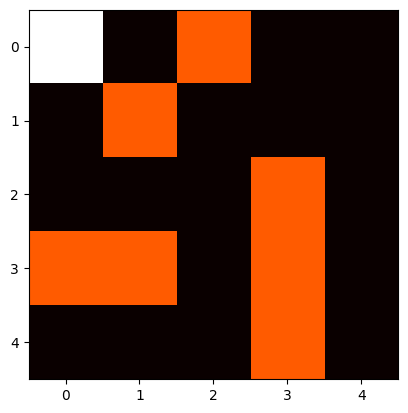

KeyboardInterrupt: 

In [4]:
# Seguir la política óptima desde el estado inicial hasta el objetivo 1
estado = estado_inicial
while estado != estado_objetivo_1:
    accion = seleccionar_accion(estado, 0.0)
    nueva_estado = mover_agente(estado, accion)
    if laberinto[nueva_estado[0], nueva_estado[1]] != 1:
        dibujar_laberinto(estado)
        direccion = obtener_direccion(accion)
        print(f"Agente se mueve de {estado} a {nueva_estado} {direccion}")
        estado = nueva_estado
    else:
        print(f"Agente intenta moverse de {estado} a {nueva_estado}, pero hay una pared")

# Seguir la política óptima desde el estado inicial hasta el objetivo 2
estado = estado_inicial
while estado != estado_objetivo_2:
    accion = seleccionar_accion(estado, 0.0)
    nueva_estado = mover_agente(estado, accion)
    if laberinto[nueva_estado[0], nueva_estado[1]] != 1:
        dibujar_laberinto(estado)
        direccion = obtener_direccion(accion)
        print(f"Agente se mueve de {estado} a {nueva_estado} {direccion}")
        estado = nueva_estado
    else:
        print(f"Agente intenta moverse de {estado} a {nueva_estado}, pero hay una pared")

# Seguir la política óptima desde el objetivo 1 hasta el objetivo 2
estado = estado_objetivo_1
while estado != estado_objetivo_2:
    accion = seleccionar_accion(estado, 0.0)
    nueva_estado = mover_agente(estado, accion)
    if laberinto[nueva_estado[0], nueva_estado[1]] != 1:
        dibujar_laberinto(estado)
        direccion = obtener_direccion(accion)
        print(f"Agente se mueve de {estado} a {nueva_estado} {direccion}")
        estado = nueva_estado
    else:
        print(f"Agente intenta moverse de {estado} a {nueva_estado}, pero hay una pared")

# Imprimir el último estado (estado_objetivo_2)
dibujar_laberinto(estado_objetivo_2)
print(f"Agente alcanzó el estado objetivo: {estado_objetivo_2}")

